This project was realized as a part of the **Deep Learning : models and optimization** class at ENSAE. It is mainly based on the paper [Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/forum?id=PxTIG12RRHS) by Yang Song  & al.

We present score based generative models in the following part, but to summarize, score based generative models are generative models which rely on the estimation of the score function defined by $\nabla_{x}log(p)$.

We reuse part of the functions found in the author's notebooks : [Tutorial on score based generative models](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing) And [Score SDE demo](https://colab.research.google.com/drive/17lTrPLTt_0EDXa4hkbHmbAFQEkpRDZnh?usp=sharing).

This notebook is composed of a first part which introduces the working framework, followed by 6 main parts.

- First, we define general functions we use throughout the notebook

- In the second part, we download the first dataset we used, which is a car dataset published by Stanford AI's lab and creating an associated dataset class.

- In the third part, we present our first attempt to score based generative models using a simple score model trained on the car dataset.

- In a second attempt, we train a more complex model proposed by the authors. Since this model has a lot of layers, we try to rely on transfer learning when training .

- Later on, we train a U-net based model proposed by the authors on our car dataset using data augmentation. 

- Finally, we train a U-net based model proposed by the authors on a simpler dataset : FashionMNIST.

My attempts to generate images similar to the images of the car dataset were not successful, although it was possible to see some car features in the sampled images, for instance for the simple model. 

This might be due to the fact that the car dataset was not large enough ($\approx$ 16000 images), and that the images were colored (3-channels) meaning that it might have been harder to learn a good score model, especially in a reasonable amount of training time. I tried to use both  transfer learning and Data augmentation to get better results, but without success.


The last part, which consisted in generating images similar to FashionMNIST images yielded good results. Learning a score model relative to this dataset was easier than for the car dataset. This is probably due to multiple factors:

- First, the images are 1-channeled, which means that the dimension of the space in which the samples live is smaller for FashionMNIST than for the car dataset.
- FashionMNIST dataset was larger, as it had both a training dataset which contained 60000 images and a test dataset which has 10000 images for a total of 70000 images.

- Here, the images were less complex than the car images, since there is more "contrast" between the items and the background, and that there is no background noise (no trees, no sky ...).

The printed losses represent the average batch loss (I am consistantly using a batch size of 64 throughout this notebook) 

The last part named "Fashion Generation" is self contained in the sense that you do not need to run the previous parts to be able to generate images. In it, you can generate new Fashion images using the last weights of the trained model.

In [ ]:
#@title We start by importing the necessary packages
from IPython.display import clear_output
!pip install torchinfo
clear_output()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
import torchinfo
import torchvision
import pickle

from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import utils
import tqdm

import os
import glob
import shutil
import pandas as pd
from torchvision.io import read_image

import matplotlib.pyplot as plt



In [ ]:
#@title Choose device to be used for the rest of the notebook
device = "cpu"#@param ["cpu","cuda"] {"type":"string"}

----------------------------------------------

#Framework

In this notebook, we aim to test and reproduce a new score based generative model / Framework introduced in the paper [Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/forum?id=PxTIG12RRHS) by Yang Song $\&$ al.

The framework proposed in the mentionned paper is a generalization of previously developed score based generative models. 

Score based generative models are generative models (which aim to sample elements of the distribution from which our dataset comes fom) which rely on learning a score based model $x \mapsto s_{\theta}(x)$ that should be as close as possible to the score function $\nabla_{x}log(p)$ of the distribution. They make use of the learned $s_{\theta}$ to generate data samples through a Monte Carlo Markov Chain method called Langevin Dynamics which only makes the distribution $p$ appear through its score function, which we approached by $s_{\theta}$. However, the way $s_{\theta}$ was learned made it so that it was not that great an approximation of the score function on low density regions. This affected the quality of the sampled data points

A more advanced developed score based model addressed the presented issue by slowly denoising the input noise vector instead of directly transforming it into a sampled data point in a single step. To do that, a noise conditionnal score based model $(x,i) \mapsto s_{\theta}(x,i)$ is learned, where we can view $i \mapsto s_{\theta}(.,i) $ as the score based model learned on $p_{x}+\sigma_{i}\mathcal{N}(0,I)$, where $\sigma_{1} < \sigma_{2}<...<\sigma_{L}$ are noise scales, and where $\sigma_{L}$ was large enough so that $p_{x}+\sigma_{L}\mathcal{N}(0,I) \approx \sigma_{L}\mathcal{N}(0,I)$.

Using this noise conditionnal score based model, it was possible with a noise vector $x_{L} \sim \sigma_{L}\mathcal{N}(0,I)$ as a starting point, to iterativelly generate a vector $x_{i-1} \sim p + \sigma_{i-1}\mathcal{N}(0,I)$ from a vector $x_{i} \sim p+\sigma_{i}\mathcal{N}(0,I)$ using $x\mapsto s_{\theta}(x,i)$ and Langevin Dynamics, to finally obtain a sample from our target that distribution.

The new model proposed by the authors is an extension of the noise conditionnal score based model, as instead of using limited noise scales it was proposed to use infinite noise scales. The resulting process was after that modeled using a Stochastic Differential equation. The idea is the same as for score based generative models, but instead of learning a noise condionnal score model, a time dependent score model was learned $(x,t)\mapsto s_{\theta}(x,t)$ where $x \mapsto s_{\theta}(x,t)$ can be seen as the score model of the process associated to the SDE at time t. 

In our case, we keep the SDE proposed in the tutorial notebook, which is a simple SDE given by :

\begin{align*}
dx = \sigma^{t}dw
\end{align*}

The associated reverse SDE is given by

\begin{align*}
dx = -\sigma^{2t}\nabla_{x}log(p_{t}(x))dt + \sigma^{t}dw
\end{align*}

#General functions and classes

In this first part, we reuse and illustrate some of the general functions presented in the Tutorial notebook proposed on [Yang Song's Blog Post](https://yang-song.github.io/blog/2021/score/).

##Time embedding class

In [ ]:
#@title First, a time embedding class to embed a scalar representing the time variable into a vector of chosen size.
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)



In [ ]:
#@title Example of use of time embedding to embed a time scalar into a vector of dimension 10
test = GaussianFourierProjection(10)
print("With an initial time of t = 0.5, we get the following embedding vector of dimension 10 :")
print(test(torch.tensor([0.5])))

With an initial time of t = 0.5, we get the following embedding vector of dimension 10 :
tensor([[-0.7376,  0.3941,  0.4990, -0.9939, -0.9839,  0.6753,  0.9191,  0.8666,
          0.1106, -0.1785]])


##Linear layer with reshaped output (to image shape)

In [ ]:
#@title A class using a simple Linear layer but reshaping the output of this layer to match an image shape
class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

In [ ]:
#@title Example of use of the previous Dense class
test_dense = Dense(3,5)
example_vect = torch.randn((2,3))
print("An example with a linear layer with entry input dimension 3 and output dimension of 5. ")
print("Using an input vector of dim",example_vect.shape,"(batch_size,sequence_size), we get the following output :")
dense_res =test_dense(example_vect)
print(dense_res)
print("of shape",dense_res.shape)

An example with a linear layer with entry input dimension 3 and output dimension of 5. 
Using an input vector of dim torch.Size([2, 3]) (batch_size,sequence_size), we get the following output :
tensor([[[[ 0.1256]],

         [[-0.1871]],

         [[ 0.4177]],

         [[ 0.0890]],

         [[ 0.0342]]],


        [[[ 0.1370]],

         [[ 0.7157]],

         [[-0.9111]],

         [[ 0.6258]],

         [[ 1.0182]]]], grad_fn=<UnsqueezeBackward0>)
of shape torch.Size([2, 5, 1, 1])


## Functions defining the Stochastic Differential Equations

In [ ]:
#@title Function to get standard deviation of $p_{0t}(x(t) | x(0))$, and function computing the diffusion coefficient (We work with a drift coefficient set to 0)

def marginal_prob_std(t, sigma=25.0):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

##Training Loss function

We wish to learn a time dependent score based model. Therefore, for each entry datapoint $x$, we generate a random associated time $t$. We then add noise to the datapoint x : here the perturbing SDE we are using is $dx = \sigma^{t}dw$, therefore we generate a random standard gaussian noise $z \sim \mathcal{N}(0,I)$ and perturb x by $\sigma(t) z$, where $\sigma(t)$ is the std of the perturbed distribution at time t.

In [ ]:
#@title Loss function

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

##SDE solvers

In [ ]:
#@title Define the Euler-Maruyama sampler. This is a simple SDE solver based on time discretization.

## The number of sampling steps.
num_steps =  50#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3,img_channels = 3, size=32):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, img_channels, size, size, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:
#@title Define the Predictor-Corrector sampler. This is the enhanced solver proposed by the authors that makes use of MCMC for better generation.

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3, img_channels = 3, size = 32):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, img_channels, size, size, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

##U-Net based model (class + torchinfo)

In [ ]:
#@title U-net based model
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,img_channels=3):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(img_channels, channels[0], 3, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, bias=False)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, bias=False)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], img_channels, 3)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information  from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
#@title U-Net based model architecture. In this case, it is for an input image with 3 channels
visualization_model=ScoreNet(marginal_prob_std_fn)
torchinfo.summary(visualization_model,input_data = [torch.randn(2,3,32,32),torch.rand((2))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Layer (type:depth-idx)                        Output Shape              Param #
ScoreNet                                      --                        --
├─Sequential: 1-1                             [2, 256]                  --
│    └─GaussianFourierProjection: 2-1         [2, 256]                  (128)
│    └─Linear: 2-2                            [2, 256]                  65,792
├─Conv2d: 1-2                                 [2, 32, 30, 30]           864
├─Dense: 1-3                                  [2, 32, 1, 1]             --
│    └─Linear: 2-3                            [2, 32]                   8,224
├─GroupNorm: 1-4                              [2, 32, 30, 30]           64
├─Conv2d: 1-5                                 [2, 64, 28, 28]           18,432
├─Dense: 1-6                                  [2, 64, 1, 1]             --
│    └─Linear: 2-4                            [2, 64]                   16,448
├─GroupNorm: 1-7                              [2, 64, 28, 28]           128


#Car Dataset

We first Aimed to apply the results and methodology presented in the above mentionned paper on a new dataset. We for instance first try to generate car images using the car image [dataset](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) published by Stanford's AI Lab.

In [ ]:
#@title First we download the car dataset.
!wget http://ai.stanford.edu/~jkrause/car196/car_ims.tgz

!mkdir "/content/dataset"
!tar -xvf  '/content/car_ims.tgz' -C '/content/dataset'
clear_output()

In [ ]:
#@title We create a dataset class to be fed to a DataLoader.
class my_dataset:

  '''Create dataset class suitable for torch dataloaders'''

  def __init__(self,img_dir,transform=None):
    
    self.img_dir=img_dir
    self.transform=transform
    paths=[img_dir+"/"+ path for path in os.listdir(img_dir)]
    self.len=len(paths)
    self.img_paths=dict(zip(range(self.len),paths))
  
  def __len__(self):
    return(self.len)
  
  def __getitem__(self, idx):
    image = read_image(self.img_paths[idx])
    if image.shape[0]==1:
      image=image.repeat(3,1,1)#There are some single channel images in the dataset
    if self.transform:
      image = self.transform(image)
    return image.float()

In [ ]:
#@title In our case, we decided to work with images of size 32*32, we therefore resize the images in the downloaded dataset to correct shape.
car_dataset=my_dataset("/content/dataset/car_ims",transform=transforms.Resize((32,32)))
print("There are",len(car_dataset),"car images in our dataset")

There are 16185 car images in our dataset


We plot a few images below. As expected, since we are using 32*32 sized images the quality is not that great. But learning a model on higher resolution images might prove time consuming and we therefore decided to go on with these low resolution images.

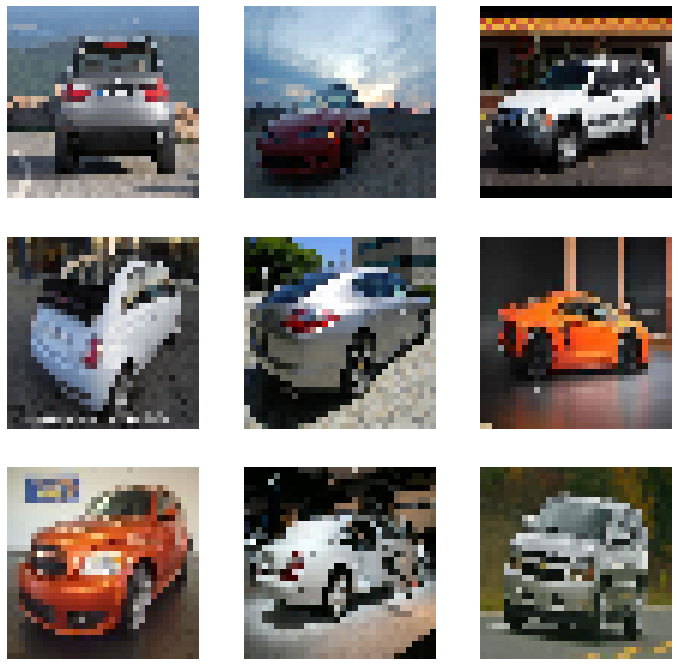

In [ ]:
#@title We plot a few car images 

def channel_f_to_channel_l(tensor_img):
  '''Function used to turn channel first images to channel last images (used for plot)'''
  np_img=tensor_img.int().numpy()
  channel_last=np.moveaxis(np_img,0,2)
  return channel_last

fig = plt.figure(figsize=(12,12))

for i in range(1,10):
  img = channel_f_to_channel_l(car_dataset[np.random.randint(len(car_dataset))])
  fig.add_subplot(3, 3, i)
  plt.axis('off')
  plt.imshow(img)
plt.show()


#Simple score model

As a first approach, we define and train a simple time-dependent score model. We describe its architecture below using torchinfo.summary.

We try to learn this simple score based model on the whole presented car dataset.

We do not split this dataset into train and test because we believed that we needed to train it with the whole dataset if we wanted to have a chance to achieve satisfying results.

In [ ]:
#@title Simple time-dependent score model

embedding_dimension=128#@param {"type":"integer"}
number_image_channels=3#@param {"type":"integer"}

class simple_score(nn.Module):
  '''Simple time dependent score-based model'''
  def __init__(self, embed_dim=embedding_dimension,img_channels=number_image_channels):
    super().__init__()
    #Time embedding
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    #First convolution + batch normalisation
    self.conv1=nn.Conv2d(img_channels,16,2)
    self.dense1=Dense(embed_dim,16)
    self.bnorm1=nn.BatchNorm2d(16)
    #Second convolution + batch normalisation
    self.conv2=nn.Conv2d(16,32,2)
    self.dense2=Dense(embed_dim,32)
    self.bnorm2=nn.BatchNorm2d(32)
    
    #First deconvolution
    self.tconv2=nn.ConvTranspose2d(32,16,2)
    self.tdense2=Dense(embed_dim,16)
    self.tbnorm2=nn.BatchNorm2d(16)
    
    #Second deconvolution
    self.tconv1=nn.ConvTranspose2d(16,img_channels,2)
    self.tdense1=Dense(embed_dim,img_channels)
    self.tbnorm1=nn.BatchNorm2d(img_channels)

    self.act = lambda x: x * torch.sigmoid(x)
    
  
  def forward(self, x, t):

    time_embed=self.embed(t)

    h1=self.conv1(x)
    h1+=self.dense1(time_embed)
    h1=self.bnorm1(h1)
    h1=self.act(h1)

    h2=self.conv2(h1)
    h2+=self.dense2(time_embed)
    h2=self.bnorm2(h2)
    h2=self.act(h2)

    th2=self.tconv2(h2)
    th2+=self.tdense2(time_embed)
    th2=self.tbnorm2(th2)
    th2=self.act(th2)

    th1=self.tconv1(th2)
    th1+=self.tdense1(time_embed)

    return(th1)


In [ ]:
#@title Torchinfo summary visualization of the simple score model Where : GaussianFourierProjection represents the time embedding layer and Dense layers are linear layers applied to the time embedding vector and reshaped at good size (basically with dummy dimensions so that the results of these layers are able to interact with the results of convolution and transposed convolution layers)
visualization_model=simple_score()
torchinfo.summary(visualization_model,input_data = [torch.randn(2,3,32,32),torch.rand((2))])

Layer (type:depth-idx)                        Output Shape              Param #
simple_score                                  --                        --
├─Sequential: 1-1                             [2, 128]                  --
│    └─GaussianFourierProjection: 2-1         [2, 128]                  (64)
│    └─Linear: 2-2                            [2, 128]                  16,512
├─Conv2d: 1-2                                 [2, 16, 31, 31]           208
├─Dense: 1-3                                  [2, 16, 1, 1]             --
│    └─Linear: 2-3                            [2, 16]                   2,064
├─BatchNorm2d: 1-4                            [2, 16, 31, 31]           32
├─Conv2d: 1-5                                 [2, 32, 30, 30]           2,080
├─Dense: 1-6                                  [2, 32, 1, 1]             --
│    └─Linear: 2-4                            [2, 32]                   4,128
├─BatchNorm2d: 1-7                            [2, 32, 30, 30]           64
├─Co

We trained the simple time-dependent model deffined above for 2*50 epochs. The loss stopped improving after 70 epochs.

In [ ]:
#@title Training the simple time-dependent score model
if device =="cuda":
  simple_score_model = torch.nn.DataParallel(simple_score())

dataloader=DataLoader(car_dataset,batch_size=64,shuffle=False)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
##learning rate
lr=1e-3 #@param {'type':'number'}

optimizer=Adam(simple_score_model.parameters(),lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x in dataloader:
    x = x.to(device)    
    loss = loss_fn(simple_score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(simple_score_model.state_dict(), 'ckpt3.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [ ]:
#@title save simple score model's state_dict
torch.save(simple_score_model.state_dict(), 'ckpt3.pth')

We now visualize the results of sampling using our simple score based model after 100 epochs of training, using the predictor-corrector sampler introduced in the article.

In [ ]:
#@title Retrieve last model's weights
!gdown https://drive.google.com/uc?id=1cJ8tPN_WKh3n4a0LrBYbSHf4m2_YQMbm
clear_output()
print("Done")


Done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


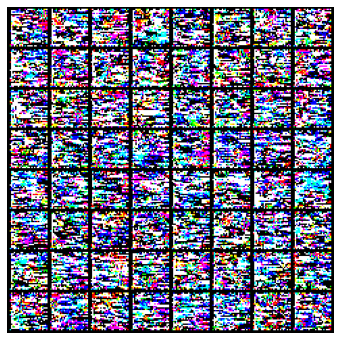

In [ ]:
#@title Sample using simple model and retrieved weights

from torchvision.utils import make_grid
simple_score_model=simple_score().to(device)
## Load the pre-trained checkpoint from disk.

ckpt = torch.load('ckpt3.pth', map_location=device)
simple_score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(simple_score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

As one could expect from a simple model generating 3 channels images trained on a few epochs and on a dataset of limited size, the results we obtained are not what one would hope for. 

Still, we can see in the generated images patterns that seem to appear, especially there seems to often be on these generated images what one could interpret as front of cars.

We decided not to spend anymore time on this model, and rather moved on to use some of the models proposed in the author's datasets

#Attempt to use Transfer learning 

In this second part, we will be using one of the more advanced models proposed in the notebook [Score SDE demo](https://colab.research.google.com/drive/17lTrPLTt_0EDXa4hkbHmbAFQEkpRDZnh?usp=sharing).

Since the model we picked has 572 layers, we will try to rely on transfer learning for learning: we will use a checkpoint file given by the authors as a starting point for our model's parameters and we will try to freeze most of the layers, and to fine tunes the remaining layers (we kept 22 layers unfrozen) on our dataset.

We will try to tune the learning rate. We decided to use a grid search model with 3 possible learning rates values, we picked values which seemed to be classically encountered : $10^{-3},10^{-2}$ and $-10^{-1}$.

What we propose to do to tune the learning rate is to train 3 different score models (using the same initial weights) with the 3 presented learning rates for 10 epochs, and to keep the model that has the lowest average loss on a training set (we will use the same training set for the 3 models) if it works well. After that, we will retrieve the model that worked best and train it a bit more if needed. Finally, we will try to generate new data samples using this trained model.

In [ ]:
#@title Once again, we use a Dataloader to load our car dataset. But in this case, we split our dataset into a train and a test set to be able to tune our hyperparameters
car_dataset=my_dataset("/content/dataset/car_ims",transform=transforms.Resize((32,32)))
nb_imgs = len(car_dataset)
indices = list(range(nb_imgs))
np.random.seed(0)
np.random.shuffle(indices)

train_size = int(0.8 * nb_imgs)
train_indices = indices[: train_size]
test_indices = indices [train_size :]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataset = DataLoader(car_dataset, batch_size = 64, sampler = train_sampler)
test_dataset = DataLoader(car_dataset, batch_size = 64, sampler = test_sampler)


In [ ]:
#@title Clone Author's git repo which contain the model and install missing modules, Insert git repo directory in sys path, import modules
!git clone https://github.com/yang-song/score_sde_pytorch.git
!pip install tensorflow_gan
!pip install Ninja
!pip install ml_collections
clear_output()

import sys
sys.path.insert(0,"/content/score_sde_pytorch")

%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

In [ ]:
#@title Download last trained model weights proposed by the authors
!gdown https://drive.google.com/uc?id=1JInV8bPGy18QiIzZcS1iECGHCuXL6_Nz

Downloading...
From: https://drive.google.com/uc?id=1JInV8bPGy18QiIzZcS1iECGHCuXL6_Nz
To: /content/checkpoint_24.pth
100% 1.00G/1.00G [00:16<00:00, 59.2MB/s]


In [ ]:
#@title Import model and load weights
from configs.ve import cifar10_ncsnpp_continuous as configs
ckpt_filename = "/content/checkpoint_24.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

batch_size =   32#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

We try out the model using the weights given by the authors (without fine tuning) to take a look at the results (similar to CIFAR)

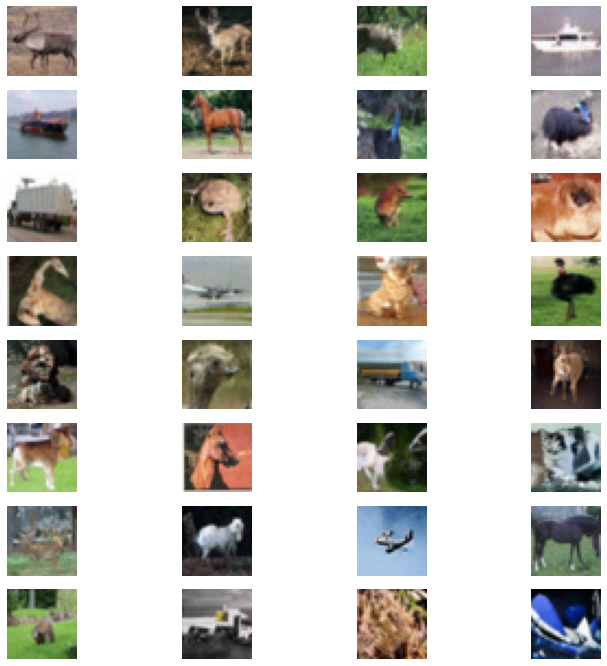

In [ ]:
#@title Example of generation using the initial model trained on CIFAR
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = EulerMaruyamaPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)


fig_2 = plt.figure(figsize=(12,12))

for i in range(1,33):
  img = channel_f_to_channel_l(255*x[i-1].detach().cpu())
  fig_2.add_subplot(8, 4, i)
  plt.axis('off')
  plt.imshow(img)
clear_output()
plt.show()

In [ ]:
#@title Number of layers in the previous model
print("There are",len(list(score_model.state_dict().keys())),"layers in this model")

There are 572 layers in this model


As mentionned, we finetune the author's model using 3 different starting learning rates.

In [ ]:
#@title We finetune the previously presented model 3 times, each time using one of the proposed learning rates.
losses_dict = {0:[],1:[],2:[]}
nb_to_freeze = 550
parameter_dict = torch.load("/content/checkpoint_24.pth")

config = configs.get_config()  

lrs = [10**(-3),10**(-2),10**(-1)]

batch_size=64
for i in range(3):
  lr = lrs[i]
  try :
    del score_model
  except :
    pass
  ckpt_filename = "/content/checkpoint_24.pth"
  config = configs.get_config()   
  config.training.batch_size = batch_size
  config.eval.batch_size = batch_size 
  score_model = mutils.create_model(config)
  ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
  state = restore_checkpoint(ckpt_filename, state, config.device)
  ema.copy_to(score_model.parameters())
  parallel_score_model  = torch.nn.DataParallel(score_model)
  k=0
  for param in score_model.parameters():
    if k<nb_to_freeze:
      param.requires_grad=False
      k+=1
    else:
      break
  train_dataset
  device = "cuda"
  tqdm_epoch = tqdm.notebook.trange(10)
  optimizer=Adam(parallel_score_model.parameters(),lr=lr)
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in train_dataset:
      x = x.to(device)    
      loss = loss_fn(score_model, x, marginal_prob_std_fn)
      losses_dict[i].append(loss.item())
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    save_name = "ckpt_model_" + str(i) + ".pth"
    torch.save(score_model.state_dict(), save_name)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Below, we present the average loss evolution for the 3 finetuned models.

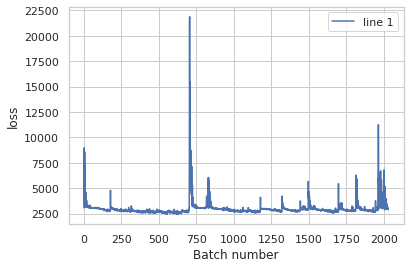

In [ ]:
#@title Model trained with learning rate 0.001
plt.plot(range(2030),losses_dict[0], label="line 1")

plt.xlabel("Batch number")
plt.ylabel("loss")
plt.legend()
plt.show()

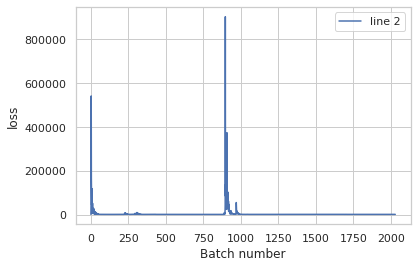

In [ ]:
#@title Model trained with learning rate 0.01
plt.plot(range(2030),losses_dict[1], label="line 2")

plt.xlabel("Batch number")
plt.ylabel("loss")
plt.legend()
plt.show()

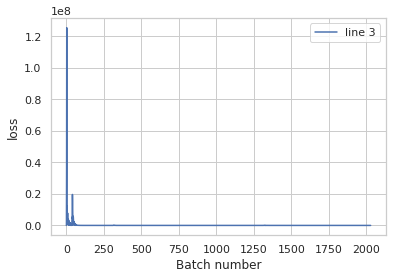

In [ ]:
#@title Model trained with learning rate 0.1
plt.plot(range(2030),losses_dict[2], label="line 3")

plt.xlabel("Batch number")
plt.ylabel("loss")
plt.legend()
plt.show()

We can easily notice that the errors are really high, especially compared to our simple model which after training had an average batch loss of 2100 for the last epoch.

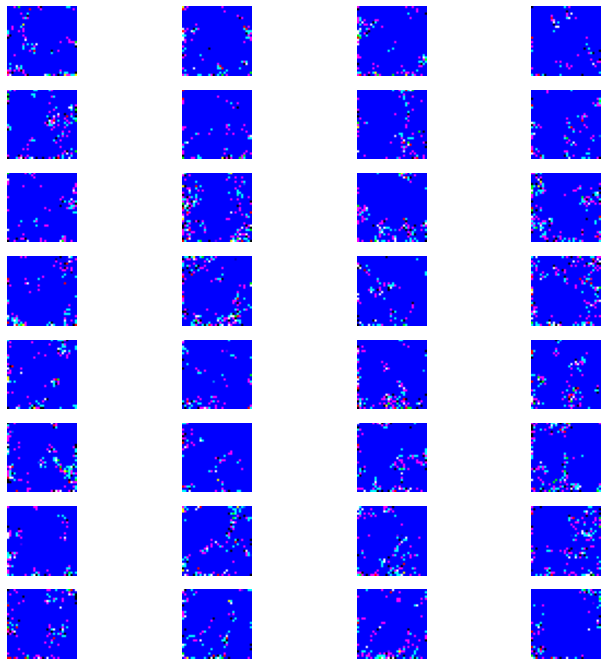

In [ ]:
#@title we try to generate sample images using the first model (lr= 0.001).
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = EulerMaruyamaPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}

sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=False,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)


fig_2 = plt.figure(figsize=(12,12))

for i in range(1,33):
  img = channel_f_to_channel_l(255*x[i-1].detach().cpu())
  fig_2.add_subplot(8, 4, i)
  plt.axis('off')
  plt.imshow(img)
clear_output()
plt.show()

The results are not at all what we expected them to be, this is probably due to the fact that we did not freeze/kept unfrozen the right layers and that the images distributions between CIFAR and our dataset are different, which might have led transfer learning not to be efficient.

We decided to drop this approach, and did not train the models trained using transfer learning any further.

#U-net based model

To achieve good results using transfer learning, we might have had to take a depeer look at the architecture of the models. But the model has 572 layers and it might be complex to proporly grasp it, we therefore decided to instead just train a less complex model from scratch. 

Since we decided not to train the previous model from scratch (might have taken a long time to train since it had 572 layers), we will be training the U-Net based score model presented in [The Tutorial notebook](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing).

We trained the U-net based model for about 100 epochs (we stopped at 83 after that the model seemed to stop improving)

In [ ]:
dataloader=DataLoader(car_dataset,batch_size=64,shuffle=False)

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
if device=="cuda":
  score_model = torch.nn.DataParallel(score_model)

n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
##learning rate
lr=1e-3 #@param {'type':'number'}

optimizer=Adam(score_model.parameters(),lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

avg_loss_list =[]

score_model.to(device)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x in dataloader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * batch_size
    num_items += batch_size
  # Print the averaged training loss so far.
  avg_loss_list.append(avg_loss)
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), '/content/ckpt.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


We sample images using the trained model

In [ ]:
#@title download model weights obtained after the 83 epochs of training
!gdown https://drive.google.com/uc?id=1rYVfL6HOZMzIsbh-BIhYjiAsDADycWNC

Downloading...
From: https://drive.google.com/uc?id=1rYVfL6HOZMzIsbh-BIhYjiAsDADycWNC
To: /content/ckpt_unet.pth
100% 4.48M/4.48M [00:00<00:00, 34.6MB/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


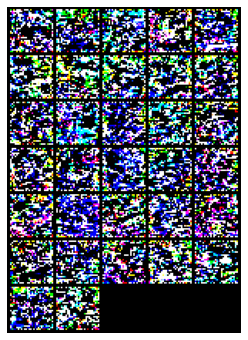

In [ ]:
from torchvision.utils import make_grid
## Load the pre-trained checkpoint from disk.

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
state_dict = torch.load('/content/ckpt_unet.pth',map_location=torch.device(device))

score_model.load_state_dict(state_dict)
sample_batch_size = 32 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Once again, the results are not satisfying. We hypothesize that this could come from different factors : 

First, we are only using a limited size dataset ($\approx$ 16000 images) which might not be enough to train a model from scratch. To solve this issue, we could try adding some data augmentation to our dataset's transforms (brightness, hue and saturation chang ; horizontal flip and color channel exchange).

A part of this could also be due to the hyperparameters we used which are a learning rate of $10^{-3}$ and a value of $\sigma$ in our SDE of 25. We use random search to tune these two parameters : we train 3 different models (which learning rates and sigmas are generated randomly in a given range) for 5 epochs each to try to choose better parameters.

In [ ]:
#@title We first create a train Dataset with transforms used for data augmentation. We also create a test dataset on which we do not apply data augmentation (no changes except resize to 32*32)

augment_transforms = torch.nn.Sequential(transforms.Resize((32,32)),transforms.ColorJitter(0.3,0.3,0.3,0.2),transforms.RandomHorizontalFlip(0.3),transforms.RandomInvert(p=0.2))
augment_car_dataset=my_dataset("/content/dataset/car_ims",transform=augment_transforms)

non_augment_dataset=my_dataset("/content/dataset/car_ims",transform=transforms.Resize((32,32)))
nb_imgs = len(augment_car_dataset)
indices = list(range(nb_imgs))
np.random.seed(0)
np.random.shuffle(indices)

train_size = int(0.8 * nb_imgs)
train_indices = indices[: train_size]
test_indices = indices [train_size :]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataset = DataLoader(augment_car_dataset, batch_size = 64, sampler = train_sampler)
test_dataset = DataLoader(non_augment_dataset, batch_size = 64, sampler = test_sampler)


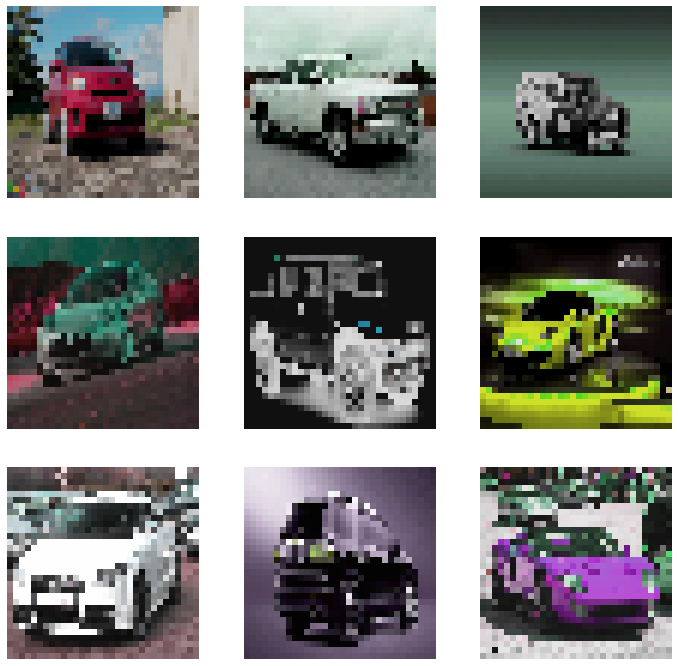

In [ ]:
#@title Example of augmented images.
fig = plt.figure(figsize=(12,12))

for i in range(1,10):
  img = channel_f_to_channel_l(augment_car_dataset[np.random.randint(len(augment_car_dataset))])
  fig.add_subplot(3, 3, i)
  plt.axis('off')
  plt.imshow(img)
plt.show()

In [ ]:
#@title Hyperparameter tuning : Using random search on the learning rate and on the value of sigma to train 3 models. (Tested values of lr and sigma printed on the shell)
min_lr = 5e-4 #@param 
min_sigma = 5
np.random.seed(5)


#Hyperparameters
tested_lr = min_lr + 0.05*np.random.rand(3)
tested_sigma = min_sigma + 40*np.random.rand(3)

print("lr tested :",tested_lr)
print("sigma tested :",tested_sigma)


losses_dict ={}

n_epochs =   5 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  64  #@param {'type':'integer'}
##learning rate

for i in range(3):

  marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=tested_sigma[i])

  score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
  score_model.load_state_dict(torch.load('/content/ckpt_unet.pth',map_location=torch.device(device)))
  
  if device =="cuda":
    score_model = torch.nn.DataParallel(score_model)
  score_model=score_model.to(device)
  dataloader=DataLoader(augment_car_dataset,batch_size=64,shuffle=False)
  


  optimizer=Adam(score_model.parameters(),lr=tested_lr[i])
  tqdm_epoch = tqdm.notebook.trange(n_epochs)

  avg_loss_list =[]

  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in train_dataset:
      x = x.to(device)    
      loss = loss_fn(score_model, x, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * batch_size
      num_items += batch_size
    # Print the averaged training loss so far.
    avg_loss_list.append(avg_loss)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), '/content/drive/MyDrive/unet_model_weights/augmented_'+str(i+1)+'_ckpt.pth')
  losses_dict[i] = avg_loss_list

with open("/content/losses_dict.pickle","wb") as f:
  pickle.dump(losses_dict,f)

with open("/content/drive/MyDrive/unet_model_weights/used_lr.pickle","wb") as f :
  pickle.dump(tested_lr.tolist(),f)

with open("/content/drive/MyDrive/unet_model_weights/used_sigma.pickle","wb") as f :
  pickle.dump(tested_sigma.tolist(),f)


lr tested : [0.01159966 0.04403662 0.01083596]
sigma tested : [41.74443632 24.53644755 29.46975452]


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#@title Download weights of the 3 models trained above
!gdown https://drive.google.com/uc?id=1IPZfdgXuEMYtBSQXpzqacOJ8ZTJNmzAD
!gdown https://drive.google.com/uc?id=1m0rxpmpJpvOe9393q7QlQw1WOQAx1a1G

!unzip "/content/augmented_ckpt.zip"
!unzip "/content/parameters_and_losses.zip"

Downloading...
From: https://drive.google.com/uc?id=1IPZfdgXuEMYtBSQXpzqacOJ8ZTJNmzAD
To: /content/augmented_ckpt.zip
100% 12.4M/12.4M [00:00<00:00, 30.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m0rxpmpJpvOe9393q7QlQw1WOQAx1a1G
To: /content/parameters_and_losses.zip
100% 753/753 [00:00<00:00, 1.26MB/s]
Archive:  /content/augmented_ckpt.zip
  inflating: augmented_2_ckpt.pth    
  inflating: augmented_1_ckpt.pth    
  inflating: augmented_3_ckpt.pth    
Archive:  /content/parameters_and_losses.zip
  inflating: losses_dict.pickle      
  inflating: used_sigma.pickle       
  inflating: used_lr.pickle          


In [ ]:
#@title Load losses, used learning rate and used sigma
with open("/content/losses_dict.pickle","rb") as f:
  losses_dict = pickle.load(f)

with open("/content/used_lr.pickle","rb") as f:
  used_lr = pickle.load(f)

with open("/content/used_sigma.pickle","rb") as f:
  used_sigma = pickle.load(f)

print("used learning rates :",used_lr)
print("used sigmas :",used_sigma)

used learning rates : [0.011599658554486976, 0.04403661530886882, 0.010835957766971322]
used sigmas : [41.744436317516865, 24.536447551793167, 29.46975451610583]


Now we want to test the 3 trained models on the non augmented test dataset we set aside, as we want to keep the one with the lowest average test loss. 

In [ ]:
#@title Computing average loss per image on our test dataset
device = "cpu"
avg_losses=[]
for i in range(3):
  marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=used_lr[i])
  score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
  score_model.load_state_dict(torch.load("/content/augmented_"+str(i+1)+"_ckpt.pth"))
  score_model.eval()
  avg_loss = 0
  nb_elements=0
  for x in test_dataset:
    x = x.to(device)
    nb_elements+=64
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    avg_loss += loss.item()
  avg_loss = avg_loss/nb_elements
  avg_losses.append(avg_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


It seems like the best model is the second one.

In [ ]:
#@title Printing Average batch loss for each model
for i,loss in enumerate(avg_losses):
  print("for a value of sigma of",round(used_lr[i],3),"and using a learning rate of",round(used_lr[i],3),"the",str(i+1),"th model achieved an average loss of",round(64*loss,3))

for a value of sigma of 0.012 and using a learning rate of 0.012 the 1 th model achieved an average loss of 3262.949
for a value of sigma of 0.044 and using a learning rate of 0.044 the 2 th model achieved an average loss of 3115.421
for a value of sigma of 0.011 and using a learning rate of 0.011 the 3 th model achieved an average loss of 3247.917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


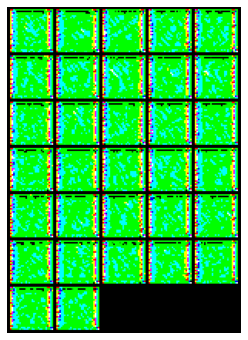

In [ ]:
#@title Generate samples using the best model trained
from torchvision.utils import make_grid
## Load the pre-trained checkpoint from disk.

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=used_lr[1])
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
score_model.load_state_dict(torch.load("/content/augmented_2_ckpt.pth"))
sample_batch_size = 32 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

This time as well, adding data augmentation seems to have completely messed up our model. 

We decided to use a simpler dataset which might require less complex techniques and might give better results.


#FashionMnist

We decided to try again but this time using a simple 1-channel dataset : FashionMNIST. 

FashionMNIST training dataset contains 60 000 images, and as the images are also 1-channel images, we can except to achieve better results than with the car dataset.

In [ ]:
#@title Import FashionMNIST dataset
from torchvision.datasets import FashionMNIST
!mkdir "/content/FashionMNIST"

In [ ]:
#@title Download FashionMNIST train set
train_FashionMnist = FashionMNIST("/content/FashionMNIST", download=True, train=True, transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()]))
fashion_MNIST_train = DataLoader(train_FashionMnist, batch_size = 64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw



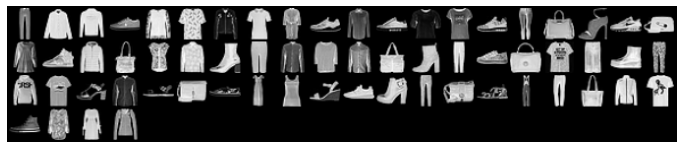

In [ ]:
#@title We plot a few FashionMNIST images 
sample = next(iter(fashion_MNIST_train))[:20]
imgs,labels = sample
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
#@title Define a Function to train U-net based model
def train_unet_model_and_save_weights(checkpoint, img_channels, dataloader, lr, sigma, device, epochs, save_weights_path, save_losses_path, ignore_data_rate = None,label=False):
  '''Function to train U-Net model
  checkpoint : if not None, path toward checkpoints from which to load model
  img_channels : 3 for color images, 1 for grayscale
  dataloader : train dataloader
  lr : learning rate
  sigma : sigma used to define SDE 
  device : cpu or cuda
  epochs : number of training epochs
  save_weights_path : path at which to save weights after each epoch
  save_losses_path : path at which to save a pickle file containing the list of average batch loss for each epoch
  ignore_data_rate : if not None, value between 0 and 1 representing the % of data to skip at training (to not train over the whole dataset)
  label : if dataset contains labels, set to True to retrive the image tensor'''
  marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma = sigma)
  score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn, img_channels = img_channels)
  if checkpoint:
    score_model.load_state_dict(torch.load(checkpoint))
  if device =="cuda":
    score_model = torch.nn.DataParallel(score_model)
  
  score_model=score_model.to(device)
  optimizer=Adam(score_model.parameters(),lr = lr)
  tqdm_epoch = tqdm.notebook.trange(epochs)
  avg_loss_list =[]

  for epoch in tqdm_epoch:
    
    avg_loss = 0.
    num_items = 0
    
    for x in fashion_MNIST_train:
      
      skip_prob = np.random.rand()
      ignore_data_rate = -1 if not ignore_data_rate else ignore_data_rate
      if ignore_data_rate > skip_prob:
        pass

      if label:
        x = x[0].to(device) 
      else:
        x = x.to(device)
      
      loss = loss_fn(score_model, x, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * 64
      num_items += 64
    
    avg_loss_list.append(avg_loss)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), save_weights_path)
  with open(save_losses_path,"wb") as f:
    pickle.dump(avg_loss_list,f)


In [ ]:
#@title Define a Function to test our U-net based models
def test_model(device, sigma, img_channels, checkpoint, test_dataset, label):
  '''Function to test a model on a test dataloader, returns average batch loss
  sigma : same sigma as SDE
  img_channels : 3 if color image, 1 if grayscale
  checkpoint : path to torch.load checkpoint file
  test_dataset : dataloader on which to test model 
  label : Boolean, if set to true retrieve first element from dataloader's output (to skip labels returned by dataloader)'''
  avg_losses=[]
  marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma = sigma)
  score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn, img_channels = img_channels).to(device)
  if checkpoint:
    score_model.load_state_dict(torch.load(checkpoint))
  score_model.eval()
  avg_loss = 0
  nb_elements=0
  for x in test_dataset:
    if label:
      x = x[0].to(device)
    else:
      x = x.to(device)
    nb_elements+=64
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    avg_loss += loss.item()
  avg_loss = avg_loss/nb_elements
  avg_losses.append(avg_loss)
  return(avg_losses)

We decided to tune 2 hyperparameters : the learning rate and sigma (which interves in the SDE).

For that, we use random search : we generate 3 values of learning rate and sigma in a given range, and using these generated values we train 3 different U-net based models for 10 epochs each.

In [ ]:
#@title Hyperparameter tuning : Using random search on the learning rate and on the value of sigma to train 3 models.
min_lr = 5e-4 #@param 
min_sigma = 5
np.random.seed(10)


#Hyperparameters
tested_lr = min_lr + 0.05*np.random.rand(3)
tested_sigma = min_sigma + 40*np.random.rand(3)

print("lr tested :",tested_lr)
print("sigma tested :",tested_sigma)

n_epochs =   10 #@param {'type':'integer'}

for i in range(3):
  save_path = "/content/drive/MyDrive/unet_fashion_model_weights/augmented_"+str(i+1)+"_ckpt.pth"
  train_unet_model_and_save_weights(None,1,fashion_MNIST_train,tested_lr[i],tested_sigma[i],device,10,save_path,"/content/losses_"+str(i)+".pickle",label=True)


with open("/content/drive/MyDrive/unet_model_weights/fashion_used_lr.pickle","wb") as f :
  pickle.dump(tested_lr.tolist(),f)

with open("/content/drive/MyDrive/unet_model_weights/fashion_used_sigma.pickle","wb") as f :
  pickle.dump(tested_sigma.tolist(),f)

lr tested : [0.03906603 0.0015376  0.03218241]
sigma tested : [34.9521553  24.94028049 13.99186582]


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#@title Download the weights of the 3 models trained above
!gdown https://drive.google.com/uc?id=1HyBIRSoX8T0Oj3pVzZvDrEqVSl2cfKj6 
!mkdir "/content/fashion_weights"
!unzip "/content/fashion_weights.zip" -d "/content/fashion_weights"

Downloading...
From: https://drive.google.com/uc?id=1HyBIRSoX8T0Oj3pVzZvDrEqVSl2cfKj6
To: /content/fashion_weights.zip
100% 12.3M/12.3M [00:00<00:00, 58.9MB/s]
Archive:  /content/fashion_weights.zip
  inflating: /content/fashion_weights/test_losses.pickle  
  inflating: /content/fashion_weights/fashion_3_ckpt.pth  
  inflating: /content/fashion_weights/fashion_2_ckpt.pth  
  inflating: /content/fashion_weights/fashion_1_ckpt1.pth  


Now what we want to do to test our models, is to evaluate their average loss on FashionMNIST's test dataset.

In [ ]:
#@title Download FashionMNIST test dataset
!mkdir "/content/FashionMNIST_Test"
test_FashionMnist = FashionMNIST("/content/FashionMNIST_Test", download=True, train = False, transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()]))
fashion_MNIST_test = DataLoader(test_FashionMnist, batch_size = 64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST_Test/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST_Test/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST_Test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST_Test/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST_Test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST_Test/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST_Test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST_Test/FashionMNIST/raw



We print below the average batch loss for each of the 3 models. The losses printed below are the average losses / per image

In [ ]:
#@title Test the models on FashionMNIST test dataset
ckpt_paths = ['/content/drive/MyDrive/unet_fashion_model_weights/augmented_1_ckpt_.pth','/content/drive/MyDrive/unet_fashion_model_weights/augmented_2_ckpt_.pth','/content/drive/MyDrive/unet_fashion_model_weights/augmented_3_ckpt_.pth']
results ={}

for i in range(3):
  results[i] = test_model(device,tested_sigma[i], 1, ckpt_paths[i],test_FashionMnist,True)
with open('/content/drive/MyDrive/unet_fashion_model_weights/test_losses.pickle',"wb") as f:
  pickle.dump(results,f)
clear_output()
for i in range(3):
  avg_loss = np.array(results[i]).mean()
  print("for model",str(i+1),"average loss is",avg_loss)

for model 1 average loss is 0.41980144286453724
for model 2 average loss is 0.33808450894514097
for model 3 average loss is 0.4676729433428496


It seems like the model with the lowest average batch loss is the second one (Learning rate of 0.0015 and sigma of $\approx$24.94). 

In [ ]:
#@title Retrieve used values of sigma and learning rate

!gdown https://drive.google.com/uc?id=1-LaaBaQhhcIMb1DaalV1Gj89TGqnysUJ
!gdown https://drive.google.com/uc?id=1A7Ps1yM2bux94O5f6KnUUlwASjH7cqg8
with open("/content/fashion_used_sigma.pickle","rb") as f:
  tested_sigma = pickle.load(f)
with open("/content/fashion_used_lr.pickle","rb") as f:
  tested_lr = pickle.load(f)

Now we train the model with the lowest test loss ($2^{nd}$ one) for more epochs : first 60 epochs

In [ ]:
train_unet_model_and_save_weights("/content/fashion_weights/fashion_2_ckpt.pth", 1, fashion_MNIST_train, tested_lr[1], tested_sigma[1],"cuda",60,"/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt.pth","/content/drive/MyDrive/unet_fashion_model_weights/best_model_losses.pickle", label=True)

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Another 50 epochs

In [ ]:
train_unet_model_and_save_weights("/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt_.pth", 1, fashion_MNIST_train, tested_lr[1], tested_sigma[1],"cuda",50,"/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt_2.pth","/content/drive/MyDrive/unet_fashion_model_weights/best_model_losses.pickle", label=True)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


A last set of 50 epochs

In [ ]:
train_unet_model_and_save_weights("/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt2.pth", 1, fashion_MNIST_train, tested_lr[1], tested_sigma[1],"cuda",50,"/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt_3.pth","/content/drive/MyDrive/unet_fashion_model_weights/best_model_losses_3.pickle", label=True)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


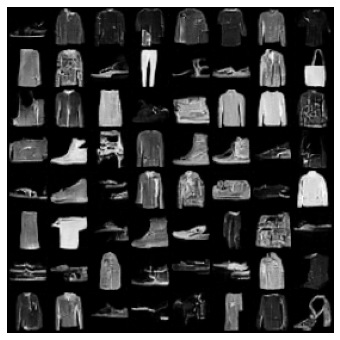

In [ ]:
#@title Finally, we sample datapoints using the last weights
from torchvision.utils import make_grid
## Load the pre-trained checkpoint from disk.

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=tested_sigma[1])
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn, img_channels = 1).to(device)

score_model.load_state_dict(torch.load('/content/drive/MyDrive/unet_fashion_model_weights/fashion_weights_best_model_ckpt3.pth'))
sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device,img_channels=1)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

#Fashion Generation

This part is self contained, you can generate samples if you run the 2 first cells which import libraries/ define classes ...

In [ ]:
#@title Choose device and num_steps. num_steps is the number of steps taken by the PC sampler. If you are on gpu I advise you to keep the default num_steps (1000) otherwise you might want to set it to 100 for example. But with only 100 steps, we get average results.

device ="cpu" #@param ["cuda","cpu"] {"type":"string"}
num_steps =  1000 #@param {"type":"integer"}

In [ ]:
#@title Run this part to import packages, define functions, download weights ...

!gdown https://drive.google.com/uc?id=1AZdacJrYsMJjql7USmJuvp83N0lejVV1

from IPython.display import clear_output
!pip install torchinfo
clear_output()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
import torchinfo
import torchvision
import pickle

from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import utils
import tqdm

import os
import glob
import shutil
import pandas as pd
from torchvision.io import read_image

import matplotlib.pyplot as plt

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

def marginal_prob_std(t, sigma=25.0):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)


signal_to_noise_ratio = 0.16

## The number of sampling steps.

def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3, img_channels = 3, size = 32):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, img_channels, size, size, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,img_channels=3):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(img_channels, channels[0], 3, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, bias=False)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, bias=False)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], img_channels, 3)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information  from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


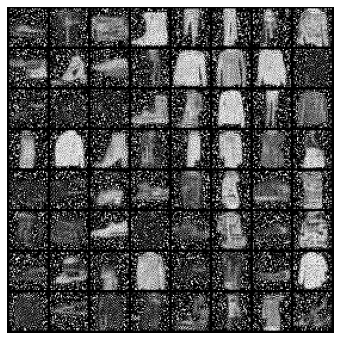

In [ ]:
#@title Sample clothes images
from torchvision.utils import make_grid
## Load the pre-trained checkpoint from disk.
sigma = 24.94028049
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn, img_channels = 1).to(device)

score_model.load_state_dict(torch.load('/content/fashion_weights_best_model_ckpt3.pth',map_location=torch.device(device)))
sample_batch_size = 64 
sampler = pc_sampler 

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device,img_channels=1)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()